# Synesthesia (with PCA)
Using (distilled) BERT and PCA to generate RGB values from embedded semantic vectors.

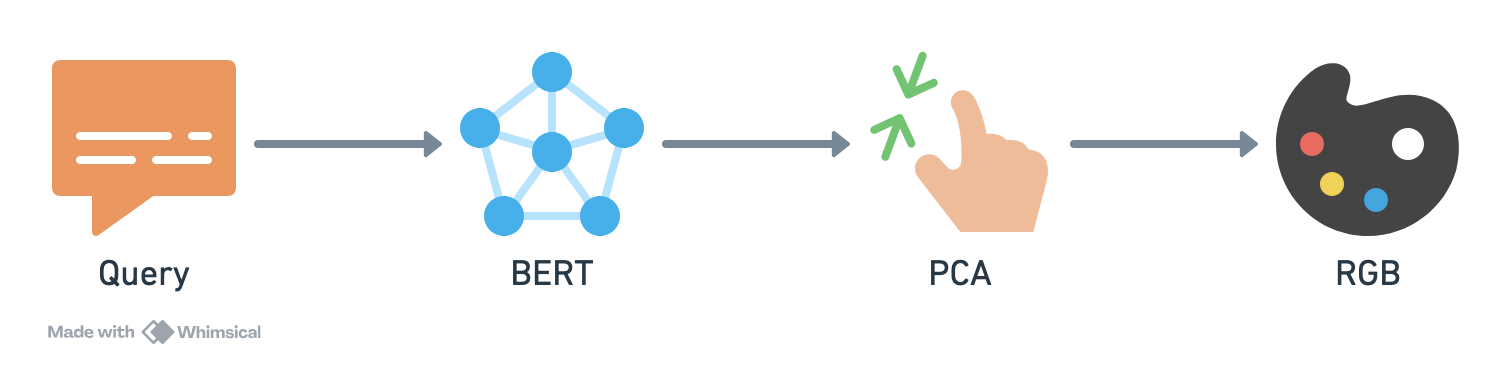

## Flow
1. Embed user query into vector using BERT
2. Reduce dimensions using PCA into tensors of size 3, using these as RGB values

In [1]:
from IPython.display import HTML, display
import math
import sagemaker
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

sagemaker.config INFO - Fetched defaults config from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix


2025-05-29 23:27:24.121434: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
session = sagemaker.Session()
sagemaker_session_bucket = None
if sagemaker_session_bucket is None and session is not None:
    sagemaker_session_bucket = session.default_bucket()

role = sagemaker.get_execution_role()
session = sagemaker.Session(default_bucket=sagemaker_session_bucket)
session

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix


In [3]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
inputs = tokenizer("Red green brown blue orange white black purple", return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

In [5]:
outputs.hidden_states[-1].squeeze().shape

torch.Size([10, 768])

In [6]:
output_embeddings = outputs.hidden_states[-1].squeeze()
output_embeddings

tensor([[-0.3546, -0.1842, -0.1997,  ..., -0.1211,  0.2737,  0.3248],
        [ 0.0032,  0.2759, -0.2800,  ...,  0.0196,  0.8776,  0.2547],
        [-0.0802,  0.3125, -0.0258,  ...,  0.1614,  0.2938,  0.1604],
        ...,
        [ 0.6108,  0.1362, -0.1696,  ..., -0.0705,  0.1517, -0.3527],
        [-0.2559, -0.2347, -0.3610,  ...,  0.0477,  0.0375, -0.0991],
        [ 0.9635,  0.0210, -0.6044,  ...,  0.0212, -0.4866, -0.3137]])

In [7]:
def vector_embed_to_rgb(embedding):
    centered_embeddings = embedding[1:-1] - embedding[1:-1].mean(dim=0, keepdim=True)

    U, S, V = torch.pca_lowrank(centered_embeddings, q=3)
    rgb_raw = torch.matmul(centered_embeddings, V)  # shape: (num_tokens, 3)

    # Normalize to 0-255 RGB range
    rgb_normalized = torch.zeros_like(rgb_raw)
    for i in range(3):
        col = rgb_raw[:, i]
        col_min, col_max = col.min(), col.max()
        rgb_normalized[:, i] = torch.floor(((col - col_min) / (col_max - col_min)) * 255)

    return torch.tensor(rgb_normalized, dtype=int)

In [8]:
rgb_vector = vector_embed_to_rgb(output_embeddings)
rgb_vector

tensor([[  0, 123, 214],
        [136, 177,   0],
        [184, 226,   1],
        [182, 207, 172],
        [182, 239, 194],
        [203, 255, 219],
        [205, 218, 255],
        [255,   0, 163]])

In [9]:
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze(0))[1:-1]
tokens

['red', 'green', 'brown', 'blue', 'orange', 'white', 'black', 'purple']

In [10]:
def display_colored_text(rgb, tokens):
    html_parts = []

    token_colors = zip(rgb, tokens)
    
    for color, token in token_colors:
        r, g, b = color
        color_hex = f"#{r:2x}{g:2x}{b:2x}"
        html_parts.append(f'<span style="color: {color_hex}; font-weight: bold; font-size: 16px;">{token}</span>')
    
    html_content = ' '.join(html_parts)
    display(HTML(html_content))

In [12]:
display_colored_text(rgb_vector, tokens)

## Notes
- PCA is capable of reducing dimensions to tensors of 3 values
- Colors are not as expected; may need further training/fine-tuning to produce colors that make sense. 